In [1]:
# This is an example of a calculation of poly(D,L-lactide) swelling in 
# supercritical carbon dioxide using Sanchez-Lacombe equation of state
# [1] I.C. Sanchez, R.H. Lacombe, Statistical Thermodynamics of Polymer Solutions, 
# Macromolecules. 11 (1978) 1145–1156. https://doi.org/10.1021/ma60066a017.
# [2] E. Kiran, Y. Xiong, W. Zhuang, Modeling polyethylene solutions in near and 
# supercritical fluids using the sanchez-lacombe model, J. Supercrit. Fluids. 
# 6 (1993) 193–203. https://doi.org/10.1016/0896-8446(93)90027-U.
# [3] Y. Xiong, E. Kiran, Prediction of high-pressure phase behaviour in 
# polyethylene/n-pentane/carbon dioxide ternary system with the Sanchez-Lacombe 
# model, Polymer (Guildf). 35 (1994) 4408–4415. https://doi.org/10.1016/0032-3861(94)90100-7.
# the parameters are taken from 
# [4] D. Liu, D.L. Tomasko, Carbon dioxide sorption and dilation of 
# poly(lactide-co-glycolide), J. Supercrit. Fluids. 39 (2007) 416–425. 
# https://doi.org/10.1016/j.supflu.2006.02.014.

In [2]:
import nlopt
import math
from numpy import *
from math import log as ln
import matplotlib.pyplot as plt

In [3]:
# PLA parameters
T_poly = 644.64 # K
P_poly = 516.72*1e6 # Pa
p_poly = 1331.3 # kg/m^3
M_poly = 28 # kg/mol
# CO2 parameters
T_scf = 269.5 # K
P_scf = 720.3*1e6 # Pa
p_scf = 1580.0 # kg/m^3
M_scf = 0.044 # kg/mol
k = {303: -0.07594, 313: -0.0765, 323: (-0.0765333 - 0.07619)/2, 333: -0.07619} #PLA/CO2 interaction parameter
data = {
    'T_poly': T_poly,
    'P_poly': P_poly,
    'p_poly': p_poly,
    'M_poly': M_poly,
    'T_scf': T_scf,
    'P_scf': P_scf,
    'p_scf': p_scf,
    'M_scf': M_scf,
    'k': k,
    'T_ext': 313,
    'P_ext': 7*1e6
}

In [4]:
# return |p^2 + P + T*[ln(1-p)+(1-1/r)+p]| value (to feed it to numerical solver)
def SLEOS(p_ext, grad, data, m_scf):
    
    #chemical system constants
    kB = 1.38064852e-23 # m^2 kg s^-2 K^-1
    R = 8.31446261815324 # kg⋅m^2⋅s^−2⋅K^−1⋅mol^−1
    T_poly = data['T_poly']
    P_poly = data['P_poly']
    p_poly = data['p_poly']
    M_poly = data['M_poly']
    T_scf = data['T_scf']
    P_scf = data['P_scf']
    p_scf = data['p_scf']
    M_scf = data['M_scf']
        
    #variable global constants
    T_ext = data['T_ext']
    P_ext = data['P_ext']
    m_poly = 1 - m_scf
    
    #get interaction coefficient
    kij = data['k'][T_ext]
    
    # calculate volume fractions
    f_scf = m_scf / p_scf / (m_scf / p_scf + m_poly / p_poly)
    f_poly = m_poly / p_poly / (m_scf / p_scf + m_poly / p_poly)
    f0_scf = f_scf * P_scf / T_scf / (f_scf * P_scf / T_scf + f_poly * P_poly / T_poly)
    f0_poly = f_poly * P_poly / T_poly / (f_scf * P_scf / T_scf + f_poly * P_poly / T_poly)
    # calculate close-packed volumes
    v_scf = R * T_scf / P_scf
    v_poly = R * T_poly / P_poly
    v_mix = f0_scf * v_scf + f0_poly * v_poly
    # calculate P* parameter
    P_mix = f_poly*P_poly+f_scf * P_scf - f_poly * f_scf * (P_poly + P_scf - 2 * (1 - kij)*((P_poly * P_scf)**0.5))
    # calculate T* parameter
    T_mix = P_mix * (f0_scf * T_scf / P_scf + f0_poly * T_poly / P_poly)
    # r-parameter calculation
    r0_scf = M_scf / p_scf / v_scf
    r0_poly = M_poly / p_poly / v_poly
    #r_scf = r0_scf * v_scf / v_mix
    #r_poly = r0_scf * v_poly / v_mix
    r_scf = r0_scf * (f_scf + v_scf * f_poly / v_poly)
    r_poly = r0_poly*(f_scf + v_scf * f_poly / v_poly) * v_poly / v_scf
    r_mix = 1 / (f0_scf / r0_scf + f0_poly / r0_poly)
    # p* (density) parameter calculation
    p_mix = 1 / (m_scf / p_scf + m_poly / p_poly)
    p_red = p_ext[0] / p_mix
    # calculate reduced parameters
    P_red = P_ext / P_mix
    T_red = T_ext / T_mix
    
    return abs(p_red * p_red + P_red + T_red * (math.log(1 - p_red) + (1 - 1 / r_mix) * p_red))

In [5]:
def find_p(p_ext, data, m_scf):
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_min_objective(lambda x,grad: SLEOS(x,grad,data,m_scf))
    p_poly = data['p_poly']
    p_scf = data['p_scf']
    m_poly = 1 - m_scf
    opt.set_ftol_rel(0.0000001)
    opt.set_maxeval(0)
    opt.set_lower_bounds([0])
    opt.set_upper_bounds([0.99999999999999 / (m_scf / p_scf + m_poly / p_poly)])
    
    return opt.optimize([p_ext])[0]  

In [6]:
# return p^2 + P + T*[ln(1-p)+(1-1/r)+p] value (to feed it to numerical solver)
def SLEOS_miu(m, grad, data):
    
    #chemical system constants
    kB = 1.38064852e-23 # m^2 kg s^-2 K^-1
    R = 8.31446261815324 # kg⋅m^2⋅s^−2⋅K^−1⋅mol^−1
    T_poly = data['T_poly']
    P_poly = data['P_poly']
    p_poly = data['p_poly']
    M_poly = data['M_poly']
    T_scf = data['T_scf']
    P_scf = data['P_scf']
    p_scf = data['p_scf']
    M_scf = data['M_scf']
        
    #variable global constants
    T_ext = data['T_ext']
    P_ext = data['P_ext']
    m_scf = m[0]
    m_poly = 1 - m_scf
    
    #get interaction coefficient
    kij = data['k'][T_ext]
    
    # calculate volume fractions
    f_scf = m_scf / p_scf / (m_scf / p_scf + m_poly / p_poly)
    f_poly = m_poly / p_poly / (m_scf / p_scf + m_poly / p_poly)
    f0_scf = f_scf * P_scf / T_scf / (f_scf * P_scf / T_scf + f_poly * P_poly / T_poly)
    f0_poly = f_poly * P_poly / T_poly / (f_scf * P_scf / T_scf + f_poly * P_poly / T_poly)
    # calculate close-packed volumes
    v_scf = R * T_scf / P_scf
    v_poly = R * T_poly / P_poly
    #v_mix = f0_scf * v_scf + f0_poly * v_poly
    v_mix = v_scf * v_poly / (f_scf * v_poly + f_poly * v_scf)
    # calculate P* parameter
    P_mix = f_poly*P_poly+f_scf * P_scf - f_poly * f_scf * (P_poly + P_scf - 2 * (1 - kij)*((P_poly * P_scf)**0.5))
    # calculate T* parameter
    T_mix = P_mix * (f0_scf * T_scf / P_scf + f0_poly * T_poly / P_poly)
    # r-parameter calculation
    r0_scf = M_scf / p_scf / v_scf
    r0_poly = M_poly / p_poly / v_poly
    #r_scf = r0_scf * v_scf / v_mix
    #r_poly = r0_scf * v_poly / v_mix
    r_scf = r0_scf * (f_scf + v_scf * f_poly / v_poly)
    r_poly = r0_poly*(f_scf + v_scf * f_poly / v_poly) * v_poly / v_scf
    r_mix = 1 / (f0_scf / r0_scf + f0_poly / r0_poly)
    # p* (density) parameter calculation
    p_mix = 1 / (m_scf / p_scf + m_poly / p_poly)
    p_ext = find_p(0.999 / (m_scf / p_scf + m_poly / p_poly), data, m_scf)
    p0_scf = find_p(p_scf*0.99, data, 1)
    # calculate reduced parameters
    P_red = P_ext / P_mix
    T_red = T_ext / T_mix
    p_red = p_ext / p_mix
    p0_scf_red = p0_scf / p_scf
    # calculate miu/RT for
    X_scf = (P_scf+P_poly-2*(1-kij)*((P_poly*P_scf)**0.5))*v_scf/R/T_ext
    miu_scf_in_poly_woRT = math.log(f_scf) + \
                           (1 - r_scf / r_poly) * f_poly + \
                           r0_scf* p_red * f_poly * f_poly * X_scf + \
                           r0_scf*(-p_red * T_scf / T_ext + \
                                   P_ext / P_scf / p_red * T_scf / T_ext + \
                                   1/ p_red * ((1-p_red)*ln(1-p_red)+\
                                               p_red*ln(p_red)/r0_scf))
    miu_scf_in_scf_woRT = r0_scf*(-p0_scf_red * T_scf / T_ext + \
                                   P_ext / P_scf / p0_scf_red * T_scf / T_ext + \
                                   1/ p0_scf_red * ((1-p0_scf_red)*ln(1-p0_scf_red)+\
                                               p0_scf_red*ln(p0_scf_red)/r0_scf))
    #print(p_ext)
    return abs(miu_scf_in_scf_woRT - miu_scf_in_poly_woRT)

In [17]:
def find_m(data):
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_min_objective(lambda x,grad: SLEOS_miu(x,grad,data))
    p_poly = data['p_poly']
    p_scf = data['p_scf']
    opt.set_ftol_rel(0.0000001)
    opt.set_maxeval(0)
    opt.set_lower_bounds([0.0000001])
    opt.set_upper_bounds([1])
    return opt.optimize([0.0001])[0] 

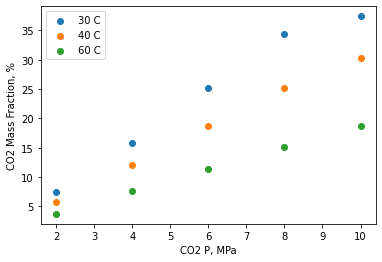

In [27]:
# Example of usage
P = [2, 4, 6, 8, 10]
w303 = []
w313 = []
w333 = []
for i in P:
    data['P_ext'] = i * 1e6
    data['T_ext'] = 333
    w333.append(find_m(data) * 100)
    data['T_ext'] = 313
    w313.append(find_m(data) * 100)
    data['T_ext'] = 303
    w303.append(find_m(data) * 100)
plt.scatter(P, w303)
plt.scatter(P, w313)
plt.scatter(P, w333)
plt.xlabel('CO2 P, MPa')
plt.ylabel('CO2 Mass Fraction, %')
plt.legend(['30 C', '40 C', '60 C'])
plt.show()